# Optimization (Part 1)

In this activity, students will add Glorot weight initializtion, and Momentum (using velocity). Look for the locations throughout the code where to implenet the student code required. 

In [1]:
import os
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
# debug printin tool
DEBUG = True
def debug(*kargs):
    if DEBUG:
        print(*kargs)

### Defining the activation functions and their derivatives

In [3]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))


def dSigmoid(x):  # derivative of sigmoid
    s = sigmoid(x)
    return np.multiply(s, (1-s))


def relu(z):  # rectified linear unit activation
    return np.maximum(0, z)


def dRelu(z):
    """ 
    Derivative of Rectified Linear Unit

    """
    return 1 * (z > 0)


# Student Coding steps:

Add Glorot weight initialization in Layer subclass function ```def initialize_weights(self, glorot=False, seed=None )```

Add momentum & velocity in Layer subclass function ```def update_Layer(self, weightUpdate, biasUpdate, momentum=0)```

In [4]:
class ANN:
    data = []
    layers = []
    inputWidth = 1
    outputWidth = 1

    class Layer:

        """class defining the elements of an ANN layer"""

        @staticmethod
        def gradl2norm(weight_vals):
            """returns the gradient of the l2 norm with respect to the weights"""
            return weight_vals
    
        @staticmethod
        def gradl1norm(weight_vals):
            """returns the gradient of the l1 norm with respect to the weights"""
            return np.sign(weight_vals)

        @staticmethod
        def l2norm(vals):
            """returns the l2 norm of the vals"""
            return np.linalg.norm(vals,ord=2)
    
        @staticmethod
        def l1norm(vals):
            """returns the l1 norm of the vals"""
            return np.linalg.norm(vals,ord=1)
        
        def __init__(self):
            self.w = []
            self.b = []
            self.lam = 0  #for weight regularization
            self.weightRegFunction = self.l2norm  #placeholder for regularization function
            self.weightRegGradFunction = self.gradl2norm   #placeholder for regularization function
            self.vel_w=[] # for standard momentum of weight gradients
            self.vel_b=[] # for standard momentum of bias gradients
            self.nodecount = []
            self.activation_fcn = []
            self.activation_fcn_derivative = []
            self.orderNumber = []
            self.previous = None  # link to previous layer
            self.next = None  # link to next layer
            

        def set_weights(self, w, b):
            """set the weights and bias for the layer.  Layer weights should have dimesion: (thislayer_nodecount, previouslayer_nodecount)
            the dimension of the bias should be (thislayer_nodecount,1)"""
            self.w = w
            self.b = b
            return self
        
        def initialize_weights(self, glorot=False, seed=None ):
            assert self.w.size > 0
            assert self.b.size > 0
            np.random.seed(seed)
            if glorot:  #use glorot initialization
                n = self.w.shape[0]
                m = self.w.shape[1]
                self.w = np.zeros(self.w.shape)   #placeholder
                # compute the edges of the glorot-specified uniform distribution and then set self.w to a uniform dist
                # note: use np.random.uniform(loweredge,upperedge,size)
                ############# STUDENT CODE - ADD GLOROT INITIALIZATION OF WEIGHTS (NOT BIASES)##############

                ###################################### END STUDENT CODE ####################################
            else:
                self.w = np.random.normal(size=(self.w.shape))  # hidden weight matrix [rows = to, columns = from]
            self.b = np.zeros(self.b.shape)  # hidden biases (column vector)
            
        def initialize_velocity(self):
            assert self.w.size > 0
            assert self.b.size > 0
            self.vel_w = np.zeros(self.w.shape)  # same shape as hidden weight matrix [rows = to, columns = from]
            self.vel_b = np.zeros(self.b.shape)  # same shape as hidden biases (column vector)
        

        def set_lambda(self, lam):
            self.lam = lam

        def set_weightRegFunction(self, fcn, d_fcn):
            self.weightRegFunction = fcn
            self.weightRegGradFunction = d_fcn
            
        def set_activation(self, activation_fcn):
            self.activation_fcn = activation_fcn
            return self

        def set_activation_deriv(self, activation_fcn):
            if activation_fcn == sigmoid:
                self.activation_fcn_derivative = copy.deepcopy(dSigmoid)
            elif activation_fcn == relu:
                self.activation_fcn_derivative = copy.deepcopy(dRelu)
            else:
                self.activation_fcn_derivative = None
                
        def display_params(self):
            """displays the weights and biases of the layer (rows = to, colums = from)"""
            for outNum in range(self.w.shape[0]):
                print(self.w[outNum,:], "  ", self.b[outNum])
        

        def compute_pre_activation(self, inputs):
            net = np.dot(self.w, inputs) + self.b
            return net

        def compute_bias_gradient(self, gradient):
            g = np.mean(gradient, axis=1)[:, np.newaxis]  # no regularization
            return g

        def compute_weight_gradient(self, inputs, gradient):
            g = np.dot(gradient, inputs.T)
            g = g/inputs.shape[1]   #divide by m (batchsize)
            return g

        def compute_activation(self, net):
            return self.activation_fcn(net)

        def compute_activation_derivative(self, net):
            return self.activation_fcn_derivative(net)

        def compute_activation_gradient(self, net, gradient):
            g = np.multiply(gradient, net)
            return g

        def compute_forward(self, inputs):
            """Returns layer ouput from input (shape = [nodeCount, input]) of the weighted input plus bias
            input shape must be [lastlayer_nodeCount, samples] or [featurecount, samplecount] """
            net = self.compute_pre_activation(self, inputs)
            layer_out = self.compute_activation(net)
            return layer_out


        def regularization_grad_weights(self,vals):
            """computes the regularization cost for the current layer weights"""
            mylam = self.lam
            myregs = self.weightRegGradFunction(vals)
            return mylam*myregs
        
        
        def compute_layer_gradients(self, net, activation, gradient):
            """ computes the loss gradient with respect to desired output of the layer
            a set of desired targets is assumed to be matrix of shape [nodecount, samples]: SGD will have [nodecount,1]
            hidden_inputs is assumed to be a matrix of shape [hiddenNodeCount, samples]
            
            This follows algorithm 6.4 line by line in the book!
            
            """
            
            # f'(a(k))
            d_activation = self.compute_activation_derivative(net)  # derivative of sigmoid:  shape = [NodeCount, samples]
            
            # g <- g * f'(a(k))
            g_loss = self.compute_activation_gradient(d_activation, gradient)  # shape = [NodeCount, samples]  for outer layer
            
            # Delta_b(k) J = g (Take the mean across all 4 samples (batch))
            g_loss_b = self.compute_bias_gradient(g_loss)  # mean gradient with respect to BIAS, shape = [NodeCount, 1]
            
            # Delta w(k) J = g * h(k-1) +lam*regularizationGrad w.r.t weights
            g_loss_w = self.compute_weight_gradient(activation, g_loss) + self.regularization_grad_weights(self.w) # [thisLayerNodecount,prevLayerOutputcount]  
            #NOTE - regularization grad weights NOT WORKING YET
            
            # g <- W(k).T * g
            g_loss_backprop = np.dot(self.w.T, g_loss)  # gradient to propagate back, shape = [hiddenNodeCount,samples]
            
            return g_loss_w, g_loss_b, g_loss_backprop

        def update_Layer(self, weightUpdate, biasUpdate, momentum=0):
            """Update weights and biases. weightUpdate is shape [thisLayerNodecount,prevLayerOutputcount]; biasUpdate is shape [thisLayerNodecount,1]"""
            if momentum == 0:  #note this if-else statement not required if written as math eq with momentum & velocity >> more efficient!
                self.w = self.w + weightUpdate
                self.b = self.b + biasUpdate
            else:  #note this if-else statement not required if written as math eq with momentum & velocity
                # need to compute the new values for self.w and self.b using momentum
                # note: momentum is passed in but velocity must be updated & stored in self.vel_w and self.vel_b
                
                junk=0 #delete this line - needed a placeholder for the else statement
                
                ############# STUDENT CODING - ADD VELOCITY TO WEIGHT & BIAS UPDATE ##################

                ############################ END STUDENT CODING  #####################################


    def __init__(self):
        self.data = []
        self.layers = []
        self.inputWidth = 1
        self.outputWidth = 1
    
        
    def set_input_width(self, inputWidth):
        """defines the input layer width for the network"""
        self.inputWidth = inputWidth

    def add_layer(self, nodecount=1, activation_fcn=relu):
        """adds a layer to the neural network and returns the layer"""
        oldLayerCount = len(self.layers)
        thislayer = ANN.Layer()
        thislayer.orderNumber = oldLayerCount + 1
        if oldLayerCount > 0:  # other layers have been added already
            lastLayer = self.layers[-1]
            lastLayer.display_params()
            thislayer.previous = lastLayer
            lastLayer.next = thislayer
            layerInputSize = lastLayer.w.shape[0]
        else:  # this will be the first layer
            layerInputSize = self.inputWidth
            
        thislayer.w = np.zeros((nodecount, layerInputSize))  #[NODECOUNT,FROM]
        thislayer.b = np.zeros((nodecount, 1 )) #[NODECOUNT,FROM]
        thislayer.vel_w = np.zeros(thislayer.w.shape)  # same shape as hidden weight matrix [rows = to, columns = from]
        thislayer.vel_b = np.zeros(thislayer.b.shape)  # same shape as hidden biases (column vector)

        thislayer.activation_fcn = activation_fcn
        thislayer.set_activation_deriv(activation_fcn)
        self.outputWidth = nodecount
        self.layers = self.layers + [thislayer]
        return thislayer
    
    def initialize(self, glorot = False, seed = None):
        """initialize weights & biases & velocity: overwrites current network parameters"""
        for layer in self.layers:
            layer.initialize_weights(glorot=glorot, seed=seed)
            layer.initialize_velocity()
            
    def setL1weightNormalization(self,lam=0):
        for idx,layer in enumerate(self.layers):
            layer.set_lambda(lam)
            layer.set_weightRegFunction(layer.l1norm,layer.gradl1norm)
            print(" Set Layer ", idx," weightNorm to gradl1norm with lambda = ", lam)
            

    def setL2weightNormalization(self,lam=0):
        for idx,layer in enumerate(self.layers):
            layer.set_lambda(lam)
            layer.set_weightRegFunction(layer.l2norm,layer.gradl2norm )
            print(" Set Layer ", idx," weightNorm to gradl2norm with lambda = ", lam)

            
    def summary(self):
        """displays a summary of the model"""
        tot_train_parameters = 0
        print("\n")
        print("Layer     Inshape     Outshape     Param #     LambdaReg")
        print("==========================================================")
        for lnum, layer in enumerate(self.layers):
            inshape = layer.w.shape[1]
            weightCount = layer.w.shape[0]*layer.w.shape[1]  #assume fully connected
            biasCount = layer.b.shape[0]
            thislayerparams = weightCount+biasCount
            tot_train_parameters += thislayerparams
            lam = layer.lam
            print("% 3d       % 3d         % 3d         %3d         %3f" %(lnum,inshape,biasCount,thislayerparams,lam))
        print("==========================================================")
        print("total trainable params: ",tot_train_parameters )
        
    def display_params(self):
        """displays the weights and biases of the network (rows = to, colums = from)"""
        print("\n")
        print("input width: ", self.inputWidth)
        for lnum, layer in enumerate(self.layers):
            print("Layer ",lnum)
            layer.display_params()
        print("output width: ", layer.w.shape[0])
                
                
    def forwardPropagation(self, inputs):
        """Compute forward pass of two layer network
        inputs are assumed to be (shape=[sampleCount,featureCount])
        returns a matrix of raw outputs with one row of output per node (shape=[sampleCount, outputNodeCount])
        Internal matrices are shaped for efficiency to avoid internal transposes (columns hold observations/samples) """

        # inputs and outputs will be transposed for efficiency during forwardPropagation and untransposed before returning

        nets = []
        activations = []
        layer_input = inputs.T

        for lnum, layer in enumerate(self.layers):
            # inputs = inputs + inputs
            layer_net = layer.compute_pre_activation(layer_input)
            nets.append(layer_net)

            layer_out = layer.compute_activation(layer_net)
            activations.append(layer_out)

            layer_input = layer_out
        raw_output = layer_out.T
        return raw_output, inputs, nets, activations

    def backPropagation(self, inputs, desiredOutputs, learningRate, momentum=0):
        w_grads = []
        b_grads = []
        # store nets and activations for each layer
        raw_output, _, nets, activations = self.forwardPropagation(inputs)
        layer_desired_out = desiredOutputs

        # Note: This is only part of the gradient
        layer_grad = desiredOutputs - raw_output
        layer_grad = layer_grad.T  #in order to match expectation for last layer output
        prev_layer_outputs = [inputs.T] + activations  #insert inputs onto activation stream for easy computations

        #  computation of full gradient handled inside the loop below
        for lnum, layer in reversed(list(enumerate(self.layers))):
            #get the input to this layer
            curr_layer_input=prev_layer_outputs[lnum]
            #get the gradients for the layer    
            w_grad, b_grad, loss_grad = layer.compute_layer_gradients(nets[lnum], curr_layer_input, layer_grad)    

            layer.update_Layer(w_grad * learningRate, b_grad * learningRate, momentum=momentum)
            layer_grad = loss_grad

    def predict(self, X, threshold=0.5):
        """Compute predictions using forward propagation for single binary classification at threshold
        X is a standard dataFrame without biases (shape=[observationCount,featureCount])
        returns a standard column vector of binary predictions in {0,1}: (shape=[observationCount, 1])"""
        raw_predictions, net_inputs, net_lst, activation_lst = self.forwardPropagation(X)
        preds = raw_predictions > threshold
        return preds

    def compute_loss(self, inputs, desired_targets):
        """computes the (scalar) loss using MSE of a set of targets and sigmoid outputs
        inputs is assumed to be a matrix of shape [samples, features]
         desired_targets is assumed to be a matrix of shape [samples, 1]"""
        raw_outputs = self.forwardPropagation(inputs)[0]
        error = desired_targets - raw_outputs
        mse = np.dot(error.T, error) / error.size
        return mse

    def fit(self, tngInputs, tngTargets, valInputs, valTargets, learningRate, learningRateDecay,
            batchsize = 1, momentum=0, valPatience=0, tolerance=1e-2, maxEpochs = 100):
        """fit model to map tngInputs to tngTargets. If valPatience > 0 then use early stopping on valInputs & valTargets
        returns training loss history and val loss history """
        done = False
        tng_loss_history = []
        val_loss_history = []
        print("Training Model...")
        epoch = 0
        #get current val performance
        valPreds = self.predict(valInputs)
        prev_val_loss = self.compute_loss(valInputs, valTargets).item()
        val_loss_history.append(prev_val_loss)
        val_epochs_nonimproved = 0
        training_count = tngInputs.shape[0]
        if batchsize>training_count: batchsize=training_count #prevent sampling beyond training size
            
        
        while not done:
            epoch+=1
            if epoch>maxEpochs: 
                done = True
            learningRate = learningRate * learningRateDecay
            tngPreds = self.predict(tngInputs)
            tngCorrect = tngTargets == tngPreds
            curr_train_loss = self.compute_loss(tngInputs, tngTargets).item()
            tng_loss_history.append(curr_train_loss)
            #evaluate validation performance
            valPreds = self.predict(valInputs)
            cur_val_loss = self.compute_loss(valInputs, valTargets).item()

            if cur_val_loss < tolerance:  #regular stopping
                done = True
                print(" --- Regular Stopping due to val loss < tolerance; val loss:", cur_val_loss)
                break
            
            # run an epoch of backprop
            #shuffle the indexes of the inputs & targets simultaneously
            order=np.random.permutation(training_count)
            #debug("range check ", np.arange(training_count))
            #debug("tng count:", training_count, ";   tng index order: ", order)
            first_tng_index=0
            last_tng_index = batchsize
            
            tinp = tngInputs[order]
            ttar = tngTargets[order]
            
            while last_tng_index<=training_count:
                #get a batch
                batchIn = tinp[first_tng_index:last_tng_index,:]
                batchTar = ttar[first_tng_index:last_tng_index,:]
                #train on the batch using backprop
                self.backPropagation(batchIn, batchTar, learningRate=learningRate, momentum=momentum)
                first_tng_index+=batchsize
                last_tng_index+=batchsize
                #handle mis-aligned training set sizes
                if first_tng_index < training_count-1 and last_tng_index>training_count-1:
                    batchIn=tinp[first_tng_index:training_count,:]
                    batchTar=ttar[first_tng_index:training_count,:]
                    self.backPropagation(batchIn, batchTar, learningRate=learningRate, momentum=momentum)
            

            # Early Stopping via VAL loss improvement
            # if validation loss has not improved in patience epochs then stop
            if cur_val_loss < prev_val_loss:
                val_epochs_nonimproved = 0
                prev_val_loss = cur_val_loss
            else:
                val_epochs_nonimproved+=1
                if valPatience > 0 and val_epochs_nonimproved > valPatience :
                    print(" --- EARLY STOPPING ACTIVATED AT val_epochs_nonimproved =  ",val_epochs_nonimproved)
                    done=True

            val_loss_history.append(cur_val_loss)
            
        print("Training Complete!")

        return tng_loss_history, val_loss_history

## Helper functions - Visualization

For displaying graphical output

In [5]:
def dataplotter(featureData, labelData, title):
    '''plot annotated points to show where the boolean inputs lie on the graph''' 

    fig, ax = plt.subplots()

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

        
#     ax.scatter(featureData[:, 0], featureData[:, 1], color='b', alpha=0.2)
    for i, txt in enumerate(labelData):
        ax.annotate(txt.item(), (featureData[i, 0], featureData[i, 1]))

        # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title(title)
    plt.show()
    




def makeDecisionBoundaryBool2(model, featureData, labelData, title):
    '''Build decision boundary figrue for 2-input, 1-output boolean logic functions
    Note that this assumes a hard sigmoid was used and establishes a cutoff at 0.5
    for predicting 0 or 1'''
    cutoff = 0.5  # 0.5 for Sigmoid. 0.0 for TANH
    fig, ax = plt.subplots()

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

    # Create filled countour map to color both sides of the boundary
    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    preds = model.predict(grid)  # get predictions
    z = preds.reshape(X.shape) > cutoff  # cutoff on predictions to return boolean output
    plt.contourf(X, Y, z, cmap='YlOrBr')

    # add annotated points to show where the boolean inputs lie on the graph
    ax.scatter(featureData[:, 0], featureData[:, 1], color='b', alpha=0.5)
    for i, txt in enumerate(labelData):
        ax.annotate(txt.item(), (featureData[i, 0], featureData[i, 1]))

        # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title(title)
    plt.show()


def show2dFunctionOutput(model_function, featureData, labelData, title):
    """display results of arbitrary model function on 2-input (x1,x2) , 1-output (z) graphs"""
    # cutoff = 0.5  # 0.5 for Sigmoid. 0.0 for TANH
    fig, ax = plt.subplots(figsize=(8,5))

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

    # Create filled countour map to color both sides of the boundary
    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    outputs, _, _, _ = model_function(grid)  # get predictions
    z = outputs.reshape(X.shape)  # reshape predictions for 2d representation
    plotlevels = np.linspace(0.,1., 25)  # split colors between 0 and 1
    CS = plt.contourf(X, Y, z, levels = plotlevels, cmap='YlOrBr')

    # add annotated points to show where the boolean inputs lie on the graph
    ax.scatter(featureData[:, 0], featureData[:, 1], color='b', alpha=0.5)
    for i, txt in enumerate(labelData):
        ax.annotate(txt.item(), (featureData[i, 0], featureData[i, 1]))

    
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('raw network output')
    # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')

    plt.title(title)
    plt.show()
    
def showLossHistory(tng_loss_history=[],val_loss_history=[],semilog=True,plotname=""):
    plt.figure()
    if semilog:
        plt.semilogy(tng_loss_history,'r', label = "Training Loss")
        plt.semilogy(val_loss_history, 'b', label = "Validation Loss")
        plt.ylabel("Loss (MSE) - semilog scale")

    else:    
        plt.plot(tng_loss_history,'r', label = "Training Loss")
        plt.plot(val_loss_history, 'b', label = "Validation Loss")
        plt.ylabel("Loss (MSE)")
    plt.xlabel("iteration")
    plt.legend()
    plt.title(plotname+" Loss over iterations")
    plt.show() 
    

---

### Helper function to produce datasets for logic gates

In [6]:
def get_input_output_data(gate='XOR'):
    """ Two dimensional inputs for logic gates

    Parameters
    ----------
    gate : str
        Must be either AND, OR, XOR

    Returns
    -------
    X : array-like, shape(samples, features)
        Two dim input for logic gates

    truth[gate] : array-like, shapes(samples, )
        The truth value for this logic gate

    """

    X = np.array([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])

    truth = {
        'AND': np.array([0, 0, 0, 1]),
        'OR': np.array([0, 1, 1, 1]),
        'XOR': np.array([0, 1, 1, 0])
    }

    return X, truth[gate][:, np.newaxis]

### Helper function to instantiate an ANN from parameters

In [7]:
def make_ANN_model(input_width = 2,
                   layer_widths = [2,1],
                   layer_activiations = [sigmoid,sigmoid],
                  glorot = False):
    model = ANN()
    print(list(zip(layer_widths,layer_activiations)))
    model.set_input_width(input_width)
    for lnum,(layerWidth,layerActivation) in enumerate(zip(layer_widths,layer_activiations)):
        model.add_layer(nodecount = layerWidth, activation_fcn=layerActivation)
    model.initialize(glorot=glorot)
    return model
        
 
    
    

---

### Helper function to train an ANN from parameters.  Allows for separate training and validation data

In [8]:
def train_ANN_model(model=None,
                    trainX = None, trainY = None,
                    valX=None,valY=None,
                    learning_rate=1.0,
                    lr_decay=0.999,
                    batchsize = 1,
                    momentum = 0,
                    valPatience=0,
                    maxEpochs = 100):
    
    

    preds = model.predict(valX)
    correct = valY == preds
    print("BEFORE TRAINING (randomized weights)")
    model.display_params()
    tng_loss_history,val_loss_history = model.fit(tngInputs=trainX, tngTargets=trainY, valInputs=valX, valTargets = valY,
                                                  learningRate=learning_rate, learningRateDecay=lr_decay, batchsize=batchsize,
                                                  momentum = momentum, valPatience=valPatience,
                                                  tolerance=1e-1, maxEpochs=maxEpochs)

    preds = model.predict(valX)
    correct = valY == preds

    print("AFTER TRAINING (learned model weights)")
    model.display_params()

    show2dFunctionOutput(model.forwardPropagation, X, Y, "Raw Response of Network")
    makeDecisionBoundaryBool2(model, X, Y, "XOR predictions from Network")

    
    showLossHistory(tng_loss_history,val_loss_history, "Loss over Iterations")


---

# Training the networks

Here we initializa a network without, and with Glorot initialization.

Students will need to implement the code in the ANN class before running the sections below.

---

# Simple network without Glorot initialization
this is a 2,1 fully connected sigmoid network.  works some of the time...

[(2, <function sigmoid at 0x000001F337028AF8>), (1, <function sigmoid at 0x000001F337028AF8>)]
[0. 0.]    [0.]
[0. 0.]    [0.]
empty model info


Layer     Inshape     Outshape     Param #     LambdaReg
  0         2           2           6         0.000000
  1         2           1           3         0.000000
total trainable params:  9
BEFORE TRAINING (randomized weights)


input width:  2
Layer  0
[-0.07333422  0.11357537]    [0.]
[-1.02859929  0.34971295]    [0.]
Layer  1
[-0.32915772  0.64488174]    [0.]
output width:  1
Training Model...
 --- Regular Stopping due to val loss < tolerance; val loss: 0.09966250518649433
Training Complete!
AFTER TRAINING (learned model weights)


input width:  2
Layer  0
[-2.06102802  1.91509856]    [0.74175803]
[-4.84298537  4.21184262]    [-2.91767439]
Layer  1
[-2.81193803  4.50992034]    [0.72521627]
output width:  1


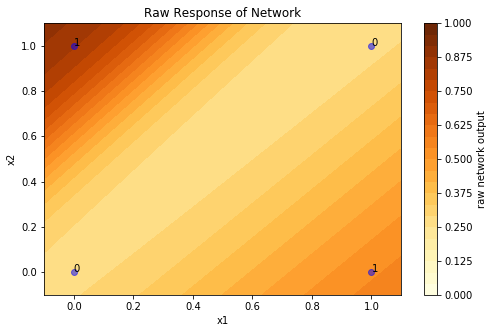

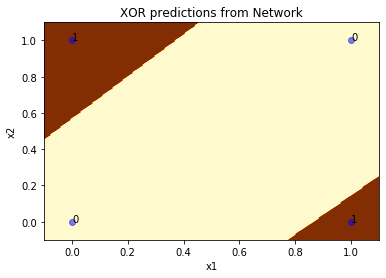

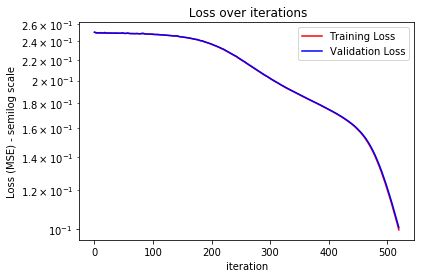

In [9]:
model = make_ANN_model(input_width = 2,
                       layer_widths = [2,1],  #number of nodes in each layer
                       layer_activiations = [sigmoid,sigmoid],
                       glorot=False)  #activations at each layer

print("empty model info")
model.summary()

X, Y = get_input_output_data(gate='XOR')

trainX = X
trainY = Y
valX = X
valY = Y

train_ANN_model(model,trainX,trainY,valX,valY,
                learning_rate=1.0,lr_decay=0.999, batchsize=1, 
                momentum = 0, valPatience = 0, maxEpochs = 5000)

# Simple network with Glorot initialization
this is a 2,1 fully connected sigmoid network.  works some of the time...

but works more often once glorot initializations are used

[(2, <function sigmoid at 0x000001F337028AF8>), (1, <function sigmoid at 0x000001F337028AF8>)]
[0. 0.]    [0.]
[0. 0.]    [0.]
empty model info


Layer     Inshape     Outshape     Param #     LambdaReg
  0         2           2           6         0.000000
  1         2           1           3         0.000000
total trainable params:  9
BEFORE TRAINING (randomized weights)


input width:  2
Layer  0
[0. 0.]    [0.]
[0. 0.]    [0.]
Layer  1
[0. 0.]    [0.]
output width:  1
Training Model...
Training Complete!
AFTER TRAINING (learned model weights)


input width:  2
Layer  0
[-4.06276971 -4.06280021]    [-0.19855574]
[-4.06276971 -4.06280021]    [-0.19855574]
Layer  1
[-3.26576821 -3.26576821]    [0.72682684]
output width:  1


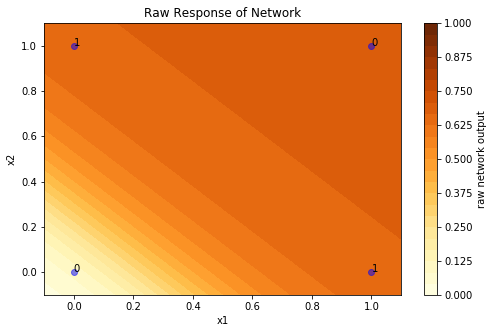

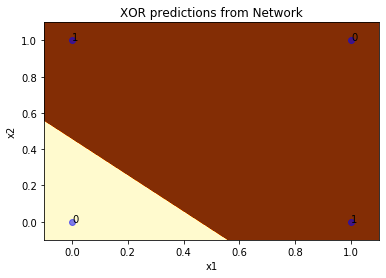

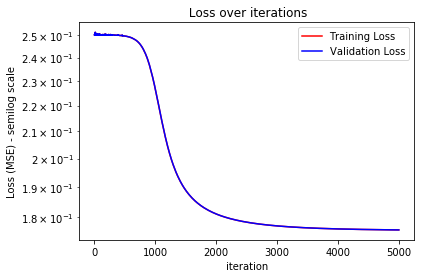

In [10]:
model = make_ANN_model(input_width = 2,
                       layer_widths = [2,1],  #number of nodes in each layer
                       layer_activiations = [sigmoid,sigmoid],
                       glorot=True)  #activations at each layer

print("empty model info")
model.summary()

X, Y = get_input_output_data(gate='XOR')

trainX = X
trainY = Y
valX = X
valY = Y

train_ANN_model(model,trainX,trainY,valX,valY,
                learning_rate=1.0,lr_decay=0.999, batchsize=1, 
                momentum = 0, valPatience = 0, maxEpochs = 5000)

# Simple Network with Momentum
this is a 2,1 fully connected sigmoid network. works more often and probably trains quicker...

[(2, <function sigmoid at 0x000001F337028AF8>), (1, <function sigmoid at 0x000001F337028AF8>)]
[0. 0.]    [0.]
[0. 0.]    [0.]
empty model info


Layer     Inshape     Outshape     Param #     LambdaReg
  0         2           2           6         0.000000
  1         2           1           3         0.000000
total trainable params:  9
BEFORE TRAINING (randomized weights)


input width:  2
Layer  0
[0. 0.]    [0.]
[0. 0.]    [0.]
Layer  1
[0. 0.]    [0.]
output width:  1
Training Model...
Training Complete!
AFTER TRAINING (learned model weights)


input width:  2
Layer  0
[0. 0.]    [0.]
[0. 0.]    [0.]
Layer  1
[0. 0.]    [0.]
output width:  1


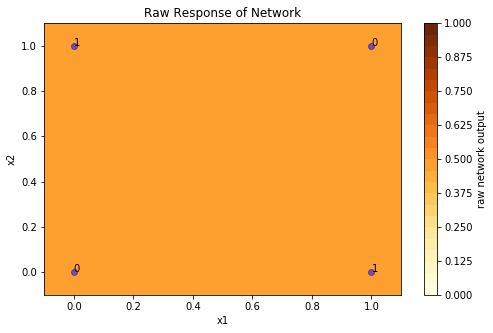

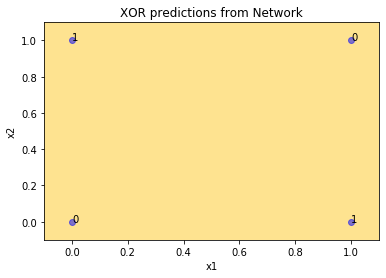

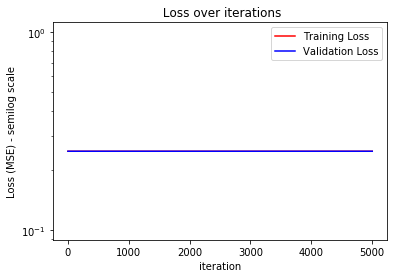

In [11]:
model = make_ANN_model(input_width = 2,
                       layer_widths = [2,1],  #number of nodes in each layer
                       layer_activiations = [sigmoid,sigmoid],
                      glorot=True)  #activations at each layer


print("empty model info")
model.summary()

X, Y = get_input_output_data(gate='XOR')

trainX = X
trainY = Y
valX = X
valY = Y

train_ANN_model(model,trainX,trainY,valX,valY,
                learning_rate=1.0,lr_decay=0.999, batchsize=1, 
                momentum = 0.7, valPatience = 0, maxEpochs = 5000)

# Higher Capacity network
 a 5-3-1 network should learn easier

In [12]:
model = make_ANN_model(input_width = 2,
                   layer_widths = [5,3,1],  #number of nodes in each layer
                   layer_activiations = [sigmoid,sigmoid,sigmoid])  #activations at each layer

print("empty model info")
model.summary()

[(5, <function sigmoid at 0x000001F337028AF8>), (3, <function sigmoid at 0x000001F337028AF8>), (1, <function sigmoid at 0x000001F337028AF8>)]
[0. 0.]    [0.]
[0. 0.]    [0.]
[0. 0.]    [0.]
[0. 0.]    [0.]
[0. 0.]    [0.]
[0. 0. 0. 0. 0.]    [0.]
[0. 0. 0. 0. 0.]    [0.]
[0. 0. 0. 0. 0.]    [0.]
empty model info


Layer     Inshape     Outshape     Param #     LambdaReg
  0         2           5          15         0.000000
  1         5           3          18         0.000000
  2         3           1           4         0.000000
total trainable params:  37


BEFORE TRAINING (randomized weights)


input width:  2
Layer  0
[0.15041147 1.33101709]    [0.]
[ 0.15122323 -0.18687539]    [0.]
[-1.00053218  1.35135594]    [0.]
[-0.61277279  2.03164707]    [0.]
[0.88763488 0.07427888]    [0.]
Layer  1
[ 1.2454468   0.32196094  1.90143899 -0.65710792  1.13071515]    [0.]
[-0.25494593 -0.81006714 -0.25047874 -1.62964093  0.13897399]    [0.]
[-0.04516478  0.05456369 -1.14221638 -0.18137693  0.35627023]    [0.]
Layer  2
[ 2.2359803  -1.04296085  0.35378813]    [0.]
output width:  1
Training Model...
 --- Regular Stopping due to val loss < tolerance; val loss: 0.09987707418611551
Training Complete!
AFTER TRAINING (learned model weights)


input width:  2
Layer  0
[1.94194854 2.12205094]    [-0.00387063]
[ 0.39476168 -0.31179986]    [-0.09306997]
[-3.16246196  2.48851432]    [-1.57493342]
[-1.97866282  3.20753864]    [0.96969489]
[0.97885722 0.25305126]    [-0.13620623]
Layer  1
[ 1.85683817 -0.01047292  3.34362929 -3.16136878  0.69703822]    [-0.7868499

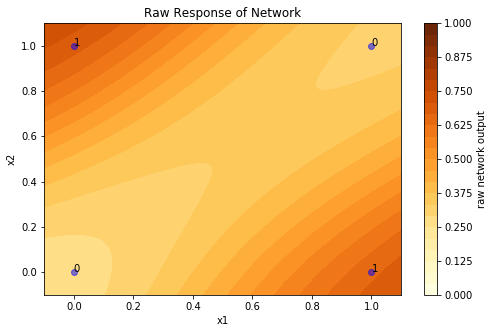

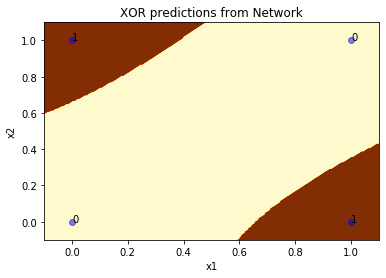

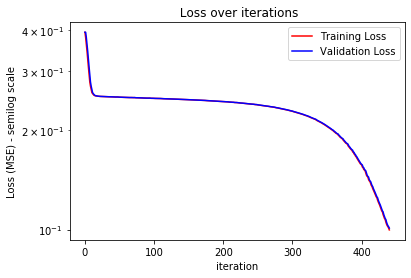

In [13]:
X, Y = get_input_output_data(gate='XOR')

trainX = X
trainY = Y
valX = X
valY = Y

train_ANN_model(model,trainX,trainY,valX,valY,
                learning_rate=0.5,lr_decay=1.0, batchsize=1, 
                valPatience = 0, maxEpochs = 5000)